# MILES-GUESS Classification Example Notebook

John Schreck, David John Gagne, Charlie Becker, Gabrielle Gantos, Dhamma Kimpara, Thomas Martin

#### Objective

This notebook is meant to demonstrate a functional example of how to use the miles-guess repository for training an evidential classification model.

Steps to get this notebook running:
1) Follow package installation steps in the miles-guess [ReadMe](https://github.com/ai2es/miles-guess/tree/main).
2) Run the cells in this notebook in order.

In [1]:
import yaml
import numpy as np
import pandas as pd

from ptype.data import load_ptype_uq, preprocess_data

from mlguess.keras.models import CategoricalDNN

2024-02-21 16:16:23.324617: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-21 16:16:25.122247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 16:16:25.122295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 16:16:25.234432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 16:16:25.385854: I tensorflow/core/platform/cpu_feature_guar

In [2]:
config = "../config/ptype/deterministic.yml"

In [3]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [4]:
conf["model"]["epochs"] = 1
conf["model"]["verbose"] = 1

In [5]:
input_features = conf["input_features"]
output_features = conf["output_features"]

# flag for our ptype model
if all([x in conf for x in input_features]):
    input_features = [conf[x] for x in input_features]
    input_features = [item for sublist in input_features for item in sublist]

metric = conf["metric"]

In [6]:
# load data using the split (see n_splits in config)
data = load_ptype_uq(conf, data_split=0, verbose=1, drop_mixed=False)

In [7]:
scaled_data, scalers = preprocess_data(
    data,
    input_features,
    output_features,
    scaler_type=conf["scaler_type"],
    encoder_type="onehot",
    groups=[]
)

In [8]:
mlp = CategoricalDNN(**conf["model"], callbacks=[])

In [10]:
mlp.fit(scaled_data["train_x"].values, scaled_data["train_y"])

6/6 [==============================] - 10s 2s/step - loss: 248.4830


In [11]:
pred_probs = mlp.predict(scaled_data["val_x"])

10/10 [==============================] - 2s 199ms/step


In [13]:
_, ale, epi, entropy, mutual_info = mlp.predict_dropout(
    scaled_data["val_x"], mc_forward_passes=10
)

/glade/work/ggantos/conda-envs/guess/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Use an evidential neural network 

In [14]:
config = "../config/ptype/evidential.yml"

In [15]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

conf["model"]["epochs"] = 5
conf["model"]["verbose"] = 1

In [16]:
ev_mlp = CategoricalDNN(**conf["model"])

In [17]:
history = ev_mlp.fit(scaled_data["train_x"], scaled_data["train_y"])

Epoch 1/5
6/6 [==============================] - 6s 656ms/step - loss: 0.7862
Epoch 2/5
6/6 [==============================] - 4s 655ms/step - loss: 0.7532
Epoch 3/5
6/6 [==============================] - 4s 627ms/step - loss: 0.7256
Epoch 4/5
6/6 [==============================] - 4s 656ms/step - loss: 0.7400
Epoch 5/5
6/6 [==============================] - 4s 647ms/step - loss: 0.7708


In [16]:
#pred_probs = ev_mlp.predict(scaled_data["val_x"])

In [18]:
pred_probs, u, ale, epi = ev_mlp.predict_uncertainty(scaled_data["val_x"])

10/10 [==============================] - 1s 102ms/step


In [19]:
name = "val"
pred_probs = pred_probs.numpy()
u = u.numpy()
ale = ale.numpy()
epi = epi.numpy()
true_labels = np.argmax(data[name][output_features].to_numpy(), 1)
pred_labels = np.argmax(pred_probs, 1)
confidences = np.take_along_axis(pred_probs, pred_labels[:, None], axis=1)
data[name]["true_label"] = true_labels
data[name]["pred_label"] = pred_labels
data[name]["pred_conf"] = confidences
for k in range(pred_probs.shape[-1]):
    data[name][f"pred_conf{k+1}"] = pred_probs[:, k]
data[name]["evidential"] = u
data[name]["aleatoric"] = np.take_along_axis(
    ale, pred_labels[:, None], axis=1
)
data[name]["epistemic"] = np.take_along_axis(
    epi, pred_labels[:, None], axis=1
)
for k in range(pred_probs.shape[-1]):
    data[name][f"aleatoric{k+1}"] = ale[:, k]
    data[name][f"epistemic{k+1}"] = epi[:, k]

In [20]:
true_labels = data[name]["true_label"].values
pred_labels = data[name]["pred_label"]
pred_probs = data[name][[f"pred_conf{k+1}" for k in range(4)]].values
confidences = data[name]["pred_conf"]

evidential = data[name]["evidential"]
total = np.sqrt(data[name]["epistemic"] + data[name]["aleatoric"])
epistemic = np.sqrt(data[name]["epistemic"])
aleatoric = np.sqrt(data[name]["aleatoric"])

In [22]:
from mlguess.classifier_uq import uq_results

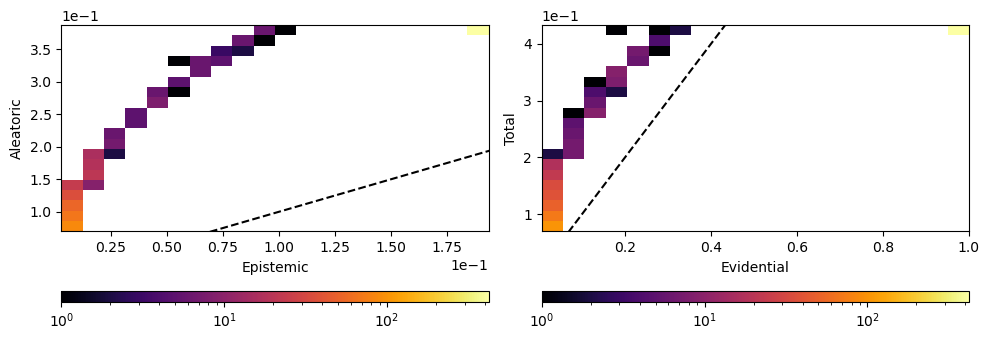

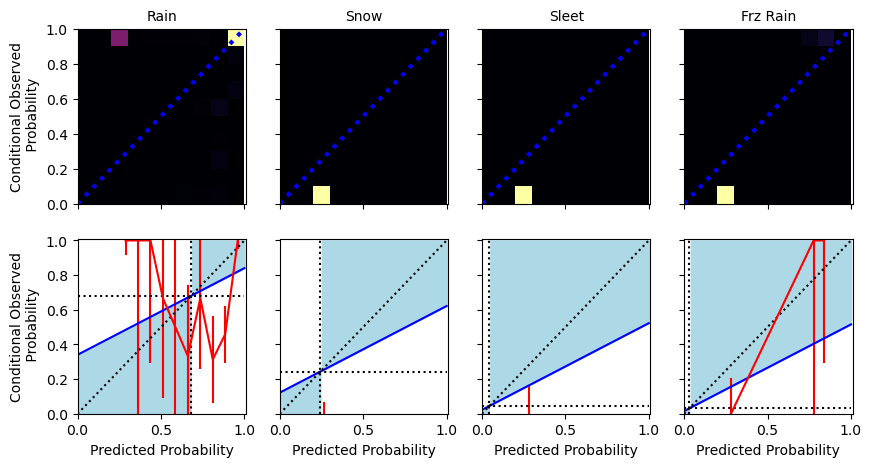

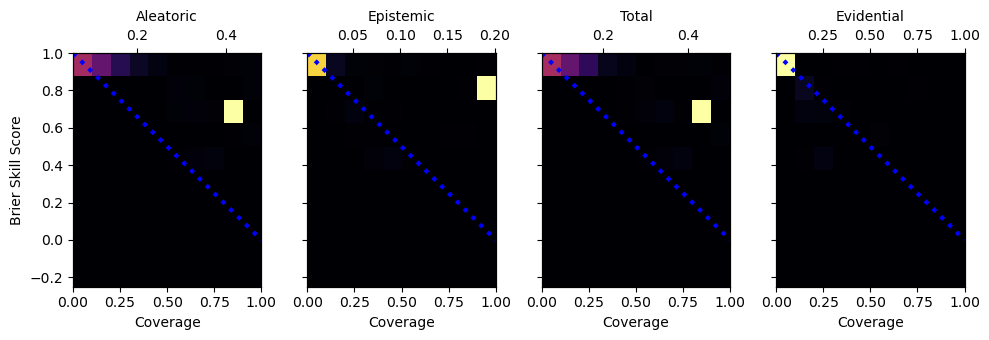

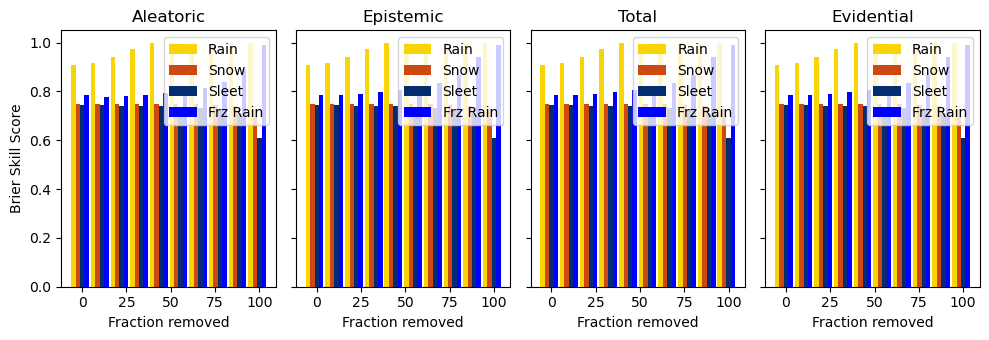

In [23]:
uq_results(data['val'], prefix='val')